# Solution NOTEBOOK

---

# Bike sharing polynomial features

## Exercise - Load and split the data, set the baseline

> **Exercise**: Load the data set. Encode categorical variables with one-hot encoding. Split the data into train/test sets with the `train_test_split()` function from Scikit-learn (50-50 split, `random_state=0`). Fit a linear regression and compare its performance to the median baseline using the mean absolute error (MAE) measure.

In [1]:
import pandas as pd
import os

# Load data
data_df = pd.read_csv(os.path.join('data', 'bike-sharing.csv'))
data_df.head()

temp    hum  windspeed  yr  workingday  holiday  weekday  season  \
0  0.344  0.806      0.160   0           0        0        6       1   
1  0.363  0.696      0.249   0           0        0        0       1   
2  0.196  0.437      0.248   0           1        0        1       1   
3  0.200  0.590      0.160   0           1        0        2       1   
4  0.227  0.437      0.187   0           1        0        3       1   

   weathersit  casual  
0           2     331  
1           2     131  
2           1     120  
3           1     108  
4           1      82

In [2]:
# One-hot encoding
encoded_df = pd.get_dummies(data_df, columns=['weekday', 'season', 'weathersit'])

encoded_df.head()

temp    hum  windspeed  yr  workingday  holiday  casual  weekday_0  \
0  0.344  0.806      0.160   0           0        0     331          0   
1  0.363  0.696      0.249   0           0        0     131          1   
2  0.196  0.437      0.248   0           1        0     120          0   
3  0.200  0.590      0.160   0           1        0     108          0   
4  0.227  0.437      0.187   0           1        0      82          0   

   weekday_1  weekday_2      ...       weekday_4  weekday_5  weekday_6  \
0          0          0      ...               0          0          1   
1          0          0      ...               0          0          0   
2          1          0      ...               0          0          0   
3          0          1      ...               0          0          0   
4          0          0      ...               0          0          0   

   season_1  season_2  season_3  season_4  weathersit_1  weathersit_2  \
0         1         0         0         0             0             1   
1         1         0         0         0             0             1   
2         1         0         0         0             1             0   
3         1         0         0         0             1             0   
4         1         0         0         0             1             0   

   weathersit_3  
0             0  
1             0  
2             0  
3             0  
4             0  

[5 rows x 21 columns]

In [3]:
from sklearn.model_selection import train_test_split

# Split into train/test sets
train_df, test_df = train_test_split(
    encoded_df, train_size=0.5, test_size=0.5, random_state=0)

print('Train DataFrame:', train_df.shape)
print('Test DataFrame:', test_df.shape)

Train DataFrame: (365, 21)
Test DataFrame: (366, 21)


In [4]:
# Create X/y variables
X_tr = train_df.drop('casual', axis=1).values
y_tr = train_df.casual.values

X_te = test_df.drop('casual', axis=1).values
y_te = test_df.casual.values

In [5]:
import numpy as np

# Mean absolute error (MAE)
def MAE(y, y_pred):
    return np.mean(np.abs(y - y_pred))

In [6]:
from sklearn.linear_model import LinearRegression

# Function to fit a linear regression
def fit_lr(X_train, y_train, X_test):
    # Create a linear regression
    lr = LinearRegression()
    
    # Fit it to train data
    lr.fit(X_train, y_train)
    
    # Compute predictions for test set
    y_pred = np.maximum(
        lr.predict(X_test),
        50 # set a lower limit
    )
    
    return y_pred

In [7]:
# Median baseline
mae_baseline = MAE(y_te, np.median(y_te))

# Linear regression
y_pred = fit_lr(X_tr, y_tr, X_te)
mae_lr = MAE(y_te, y_pred)

print('MAE baseline: {:.3f}'.format(mae_baseline))
print('MAE linear regression: {:.3f}'.format(mae_lr))

MAE baseline: 502.634
MAE linear regression: 246.833


## Exercise - Add polynomial features

> **Exercise**: Add the `temp^2` and `temp^3` polynomial features. Then fit and evaluate a linear regression. Plot your model with a scatter plot of temperatures vs. number of users. Feel free to add other features.

In [8]:
# Function to add features
def create_features(df):
    temp = df.temp.values
    others = df.drop(['temp', 'casual'], axis=1).values
    return np.c_[temp, temp**2, temp**3, others]

In [9]:
# Create new input matrices
X_tr2 = create_features(train_df)
X_te2 = create_features(test_df)

# Fit a linear regression
y_pred_lr = fit_lr(X_tr2, y_tr, X_te2)
mae_lr2 = MAE(y_te, y_pred_lr)
print('MAE lr with new features: {:.3f}'.format(mae_lr2))

MAE lr with new features: 227.667


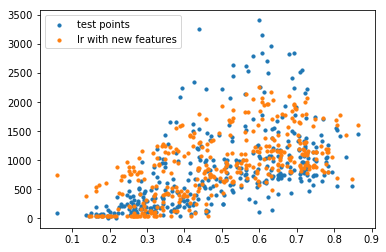

In [10]:
# Plot predictions
%matplotlib inline
import matplotlib.pyplot as plt

plt.scatter(test_df.temp, test_df.casual, s=10, label='test points')
plt.scatter(test_df.temp, y_pred_lr, s=10, label='lr with new features')
plt.legend()
plt.show()

## Exercise - Separate sources

In the last exercise, we saw that we can identify two sources in the data.

1. Data points collected during working days
1. Data points collected during non-working days

The goal of this exercise is to create a model for each source using your extended set of features, e.g., the original features plus the `temp^2`, `temp^3` polynomial features.

> **Exercise**: Create a model for each source with the extended set of features, and evaluate the overall performance on the test set using MAE. Plot the two models with a scatter plot of temperatures vs. number of users. Create a final comparison using a bar chart.

In [11]:
# Split data into working days (wd) and non-working days (nwd)
train_df_wd = train_df[train_df.workingday == 1]
train_df_nwd = train_df[train_df.workingday == 0]

test_df_wd = test_df[test_df.workingday == 1]
test_df_nwd = test_df[test_df.workingday == 0]

In [12]:
# Fit two linear regressions
y_pred_wd = fit_lr(
    create_features(train_df_wd),
    train_df_wd.casual,
    create_features(test_df_wd)
)
y_pred_nwd = fit_lr(
    create_features(train_df_nwd),
    train_df_nwd.casual,
    create_features(test_df_nwd)
)

# Reassemble predictions
y_pred_wdnwd = np.concatenate([y_pred_wd, y_pred_nwd])
y_te_wdnwd = np.concatenate([
    test_df_wd.casual,
    test_df_nwd.casual
])

# Compute MAE
mae_wdnwd = MAE(y_te_wdnwd, y_pred_wdnwd)
print('MAE two sources: {:.3f}'.format(mae_wdnwd))

MAE two sources: 179.602


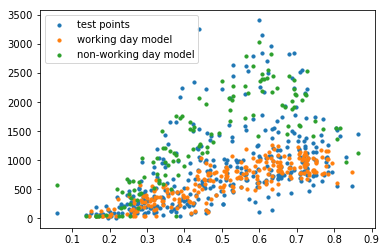

In [13]:
# Plot predictions
temp_te_wdnwd = np.concatenate([test_df_wd.temp, test_df_nwd.temp])
plt.scatter(temp_te_wdnwd, y_te_wdnwd, s=10, label='test points')
plt.scatter(test_df_wd.temp, y_pred_wd, s=10, label='working day model')
plt.scatter(test_df_nwd.temp, y_pred_nwd, s=10, label='non-working day model')

plt.legend()
plt.show()

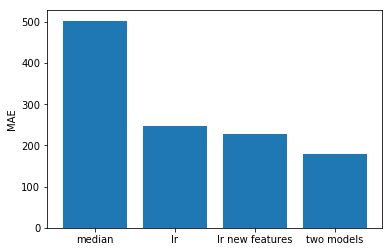

In [14]:
# Final comparison
mae_values = [mae_baseline, mae_lr, mae_lr2, mae_wdnwd]
titles = ['median', 'lr', 'lr new features', 'two models']

xcor = np.arange(len(mae_values))
plt.bar(xcor, mae_values)
plt.xticks(xcor, titles)

plt.ylabel('MAE')
plt.show()